**Covid19 SEIR feed back model for better forecast - Compare country strategies**

DRAFT  Several improvements in code but not yet commented here.

This script is modelling an epidemic outburst for a specified country, 
for example Italy or any other country in the connected dataset. 

By simulating several countries, interesting differences can be observed.
All data is made relative, equal in size, using population data. 
So small or big does not matter. As a swedish native I am much 
interested to compare the outcome from Swedens more free approach to 
for instance Italy's more closed lockdown strategy. 

The forecast delivered in this work here is completely experimental
and output is not validated in any way. Not for professional use.
If you are a professional engaged in the Covid19 outbreak and searching 
a forecast to make decision by, I recommend 
you to visit https://covid19.healthdata.org/united-states-of-america


The first used datasets is external data from Johns Hopskins University, the 
daily updated "time_series_covid19_confirmed_global.csv"
Many countries are available in this dataset, unfortunately not USA.
You can solve this by changeing to a USA specific dataset from Johns Hopskins.

The second used dataset is internal public from kaggle imported as 
/kaggle/input/countryinfo/covid19countryinfo.csv  249x60

I have pulilshed a third data set with population for Swedish counties. Used for forecasting for Swedish regions. 
/kaggle/input/regions/Sverige.xlsx

The outpus is a panel of four diagrams for each country presenting 
data in six diagrams: 

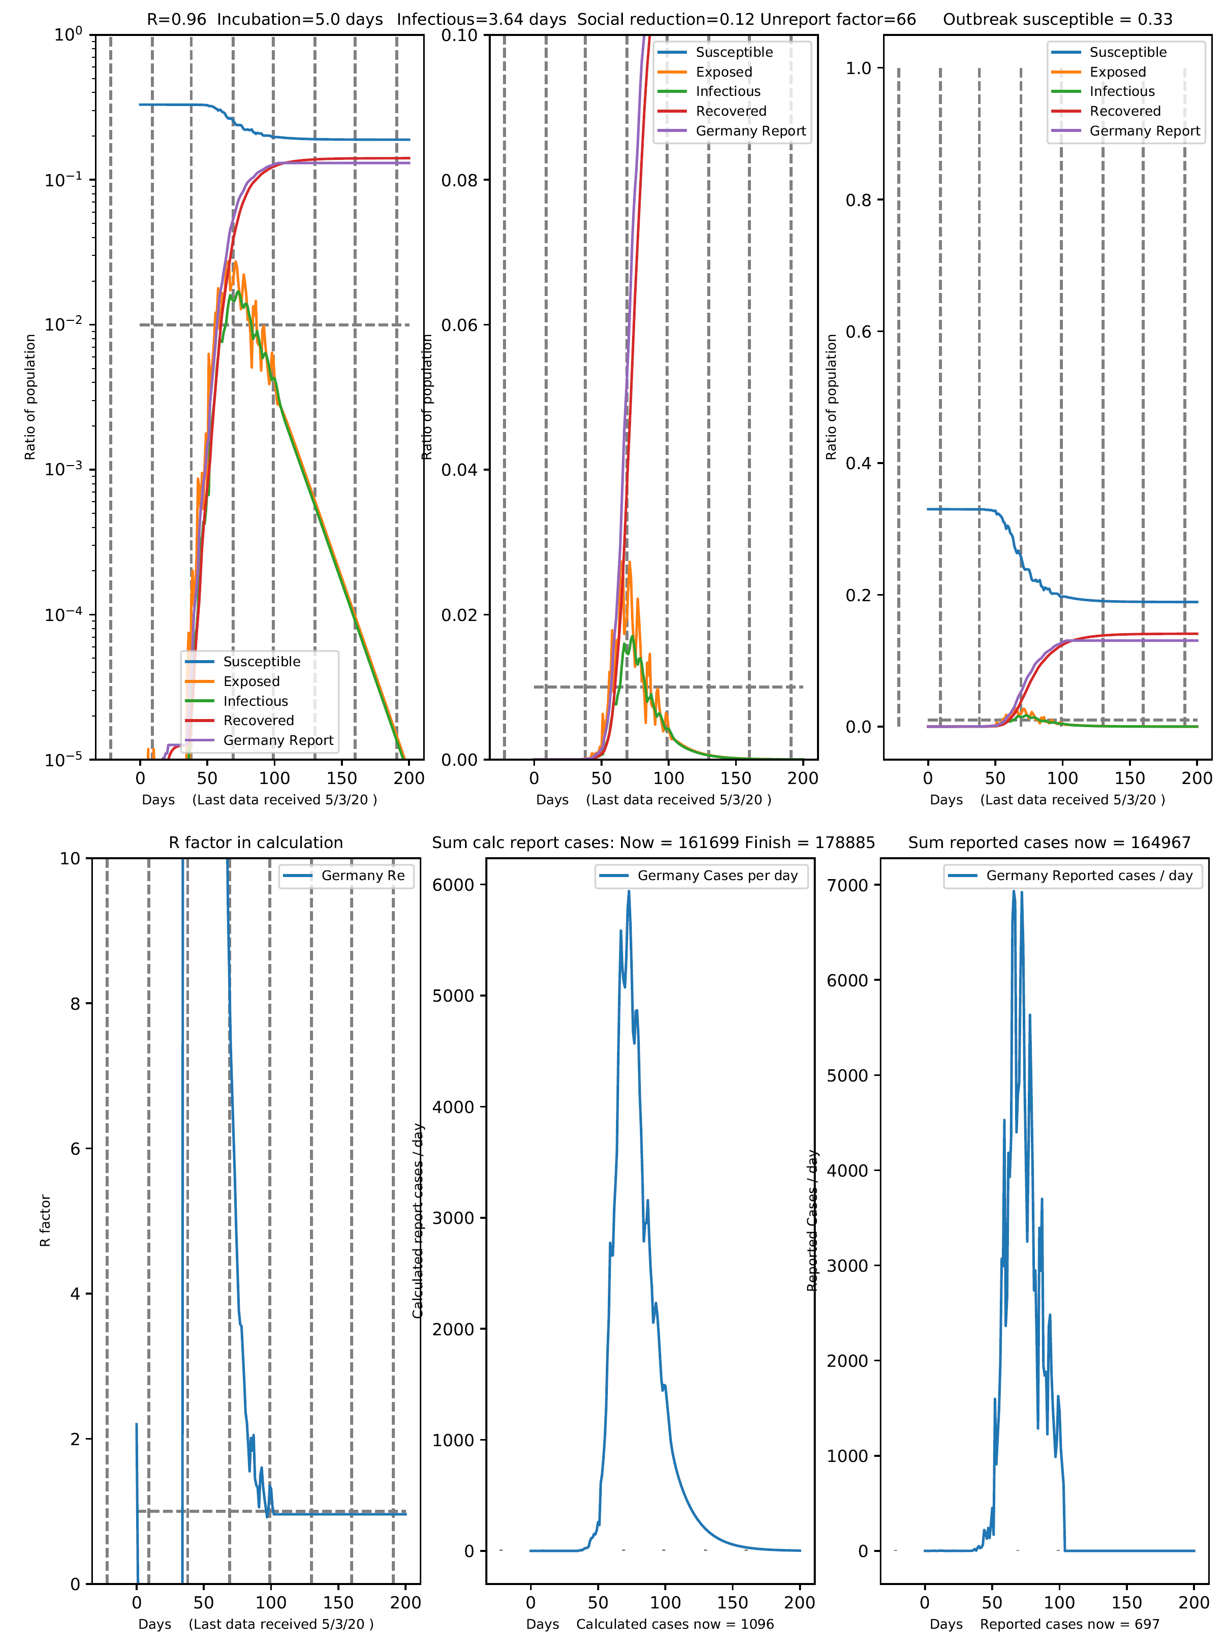

fig. 1

Three of the diagrams are similar, just different Y-scales and limits
so that both details and the big picture can be easily observed. 

The fourth diagram is presenting the critical reproduction factor R.

The fifth diagram is converting the "Infectious" cureve in to the daily
rate of approximately reported cases.  This data is obtained from the SEIR model 
and tends to be a little bit lower than real reported data. 
In the diagram header there is also given the ackumulated number to the day from the
SEIR model as well as the forecasted ackumulated number at the end of the diagram, 
the finish time. The sixth diagram present the reported case.


Typical it is possible to, for instance, read out the level of herd immunity and how 
long the outbreak will last and the intensity.

The model used, as mentioned, is the frequent used SEIR-model modified with a 
parameter for social distancing, the social reduction rho.

Time is short in this epedemic situation, so here will not be more writing about SEIR models.  
A very good and quick explanation is found in this link:
https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
The auther Christian Hubbs inspired me to start this project, thanks to his briliant and 
clear lecture in this blogg.

To get a more precise and reliable prognose, from today and beyond, the SEIR model need be 
modulated by the historical data. This is done in a way using the mentioned parameter 
for social reduction, rho.  A "regulator" adjust the rho parameter for each time step so 
that the simulation output matches the historical data. No longer explanation of this from now. 
I hope the following pictures and the code  will help you using it and hopefully also modify 
and improve on it.


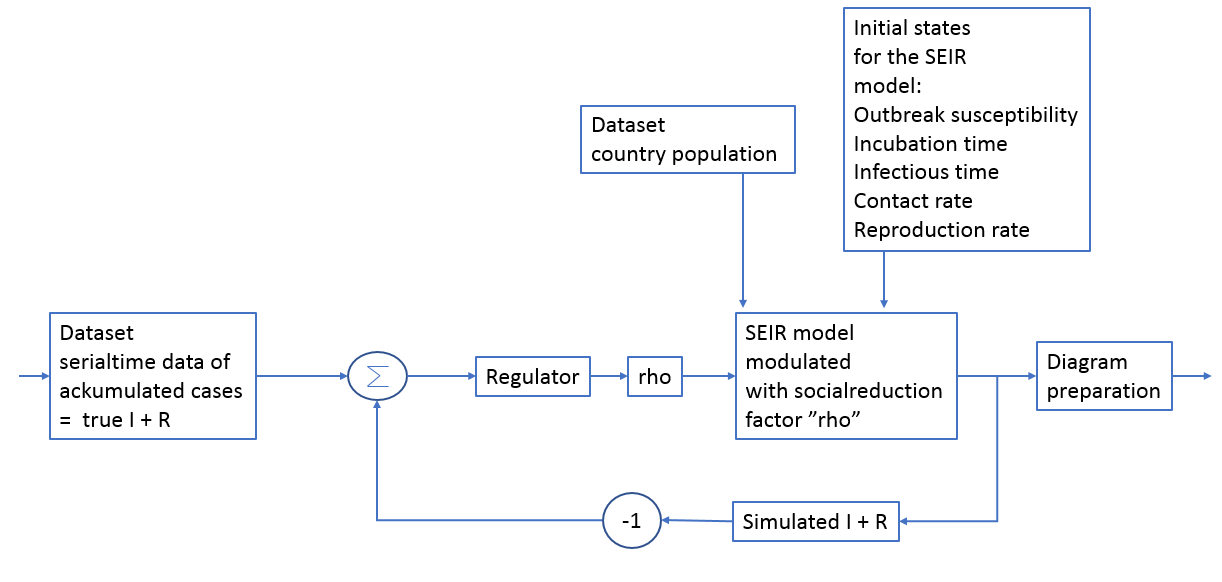
fig. 2

The way I learned the form of coupled differentiell equations, like the one used in the SEIR model is from the noble art of control technology. So the step was not so big to just enter the SIER model in to a classic control loop for a negative feed back system.

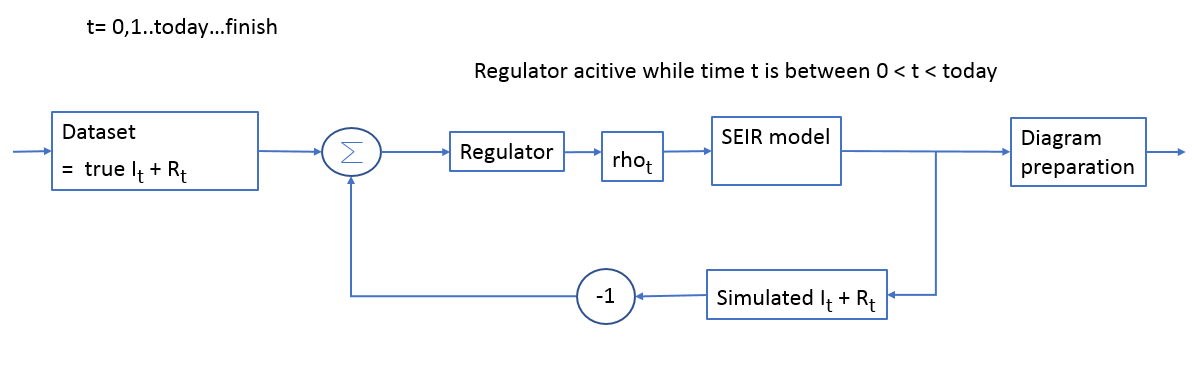
fig. 3

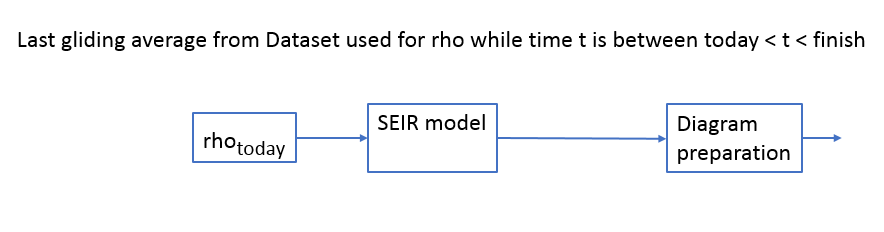
fig. 4

Ok you got the picture how this is working now? Good! Just edit and run the code. I am new to Kaggle, this is my first project here. I hope at least the links to the dataset is correct and that everythting will work.

Latest update is a datasets for the local Swedish regions and impelmentation of this.  The nootebok can in fact run in a batch like mode and output pdf diagram reports so an easy compilation of the state can be otained. 
A third cell is added for similar batch work, but for your list of countries instead.  An extra smoothining gliding average can be turned on if indata is to noisy and creates unwanted oscillations. 

I hope you will find this humble proposal useful and easy to copy and refine.  I will be happy to discuss and assist. Thanks to the community for many great
notebooks out there. I have learned a lot. 

/Goran

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# fresch start
#Note that several variables are made global in defined functions.  This was a quick fix to be able to run 
# implementation of the regulator, the singel_step function, that actual always repeat the last day step so it 
# does in a way two steps and the secant function, that calcutate the rho values.

prev_case = 0

#import numpy as np
import matplotlib.pyplot as plt
import csv
from openpyxl import load_workbook
import io
import requests
import re  # For white washing in func get_population
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib.backends.backend_pdf import PdfPages
 

def test_some(funk):
    print(funk)
    return ("yes it "+funk)

def double_step(rho,rel_case):
    global params,S, E, I, R, sum_IR
    global alpha, beta, gamma, dt
    global next_S, next_E, next_I, next_R, next_IR
    test = s_red
    
    if (len(S)>2):   
        #This extra step, recalling last days step, is necesarry to 
        # make a change in rho be visible in 
        # in all functional states ("compartments of the SEIR model")

        S[-1] = S[-2] - (rho*beta*S[-2]*I[-2])*dt
        E[-1] = E[-2] + (rho*beta*S[-2]*I[-2] - alpha*E[-2])*dt
        I[-1] = I[-2] + (alpha*E[-2] - gamma*I[-2])*dt
        R[-1] = R[-2] + (gamma*I[-2])*dt   

    #This is the actual model updating step
    next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt
    next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
    next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
    next_R = R[-1] + (gamma*I[-1])*dt  
    
    #print ("The delta: ",next_IR - rel_case)
    next_IR =next_I+next_R     #hmm are not all reported cases members of recovered group thinking of time delay from
    #exposure, infectious and then some more delay until tested in ward as a serious case?
    
    #next_IR =next_R +0.0    # Lets test this instead but didn't work no roots available But R is not steer
    
    #print("BP 67 nex IR ",next_IR)
    
    return (next_IR - rel_case)
    

def secant(x1, x2, E, rel_case): 
    # https://www.geeksforgeeks.org/program-to-find-root-of-an-equations-using-secant-method/
    n = 0; xm = 0; x0 = 0; c = 0;
    global rho, prev_case, filter
    if filter: 
    
        rel_case = (prev_case + rel_case/3)/(1+1/3)      #Some filtering. Give a couple of days time delay but nicer lines.
    
    fx1= double_step(x1,rel_case) 
    fx2= double_step(x2,rel_case)
    if (fx1 * fx2 < 0): 
    
        while True:  
            fx1= double_step(x1,rel_case) 
            fx2= double_step(x2,rel_case)  
            # calculate the intermediate value  
            x0 = ((x1 * fx2 - x2 * fx1) / (fx2 - fx1))  
  
            # check if x0 is root of  
            # equation or not 
            fx0 = double_step(x0,rel_case)       
            c = fx1 * fx0 
  
            # update the value of interval  
            x1 = x2  
            x2 = x0  
  
            # update number of iteration  
            n += 1  
  
            # if x0 is the root of equation  
            # then break the loop  
            if (c == 0):  
                break; 
            fx1= double_step(x1,rel_case) 
            fx2= double_step(x2,rel_case)            
                   
            xm = ((x1 * fx2 - x2 * fx1) / (fx2 - fx1)) 
              
            if(abs(xm - x0) < E): 
                break 
          
        #print("Root of the given equation =",  
                               #round(x0, 6)) 
        
        rho = x0*1.00          #This is test with reduction of amplification.  Important for smaller regions 
                                #that might have more fluctuations in data
        if rho > 10:
            print("Warning, big transient in input data, forecst may be less accurate")
        
        #print("No. of iterations = ", n)  
          
    else: 
        print("Can not find a root in ", 
                   "the given inteval") 
        rho = 1  #Just to avoid huge transients in the beginning
        
    prev_case = rel_case    
    return x0    




def live_data(country, region, unreport_factor, population):

    # population for the used data, used to divide to get a relative value
    # A complication is that countyr data is ackumulated cases in time serial
    # and region data is reported case numbe for each day. 
    global last_date
    global last_case
    

    r = 0.0
    IR = [0.0]       # now Infected and now recovered = total infected corresponding  to reported clinical cases
    #IR_temp = [0,0]
    Iday = [0.0]
    
    # Dataset with daily updated cases for the seleted country collectedfrom Johns Hopkins univerity, USA
    
    if (region == ""): 
    
        confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
        print("Dataset cases: ", confirmed_url )
        # time_series_covid19_confirmed_global.csv
        # csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
        url = confirmed_url
        s = requests.get(url).content
        cases = pd.read_csv(io.StringIO(s.decode('utf-8')))


        #Homogenize some country names, to make them compatible accross datasets

        cases['Country/Region'] = cases['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
        cases['Country/Region'] = cases['Country/Region'].replace('Taiwan*', 'Taiwan')
        cases['Country/Region'] = cases['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
        cases['Country/Region'] = cases['Country/Region'].replace('Korea, South', 'South Korea')
        for ii in range(len(cases.index)):  
            # This make combines region into country column as "Denmark Faroe Island" resp only "Denmark"
            if str(cases.iat[ii,0]) != "nan":
                cases.iat[ii,1] = str(cases.iat[ii,1]) + " " + str(cases.iat[ii,0])
                #print("added names", cases.iat[ii,1])

  
        ma = np.where(cases["Country/Region"] == country)[0] # Get the row number ?
        country_count = abs(cases.iloc[ma, 4:].sum(axis=0)) # Case ackumulated, increasing for each day = I+R note "abs" since weird neg numbers
                                                            # in some reports
        
        #reported_cases = cases.iloc[ma, 4:].sum(axis=0)  #Save a copy to use to calcualte reported cases per day

        rrr = cases.iloc[ma, 6]

        #print("BP 174 country_count ",country_count)
        #print("BP 175 reported_cases", reported_cases)
       
        #print("Number reported days ", len(country_count))
    
        last_case = int(float(len(country_count))*lenght_case)  # To be able to check the forecast accuracy we
        # can make a run using less than all of the available cases in the data set.  For instance test with 
        #lenght_case = 0.5   Normal full lenght  = 1.0
        
        reported_cases =np.array(country_count)
        
        #for mm in range(0, len(country_count)):   #for i in range(0, len(country_count+4)):  hardly needed  + 4
        
            #reported_cases[mm] = int(country_count[mm])
            
            
        #print(" BP190 last_case ", last_case)
        
        for pp in range((last_case-1),1,-1):  # calculating cases per day
            #print("BP193 pp,", pp)
            reported_cases[pp]= abs(reported_cases[pp]-reported_cases[pp-1])     #"abs" for weird report figures in some reports
          
        #print(" BP195 reported cases ", reported_cases)
        
        last_date = cases.iloc[ma, len(country_count)+3].name  # make sense
    
        print("The date label on the last column i cases ", last_date)
    
    elif ((country == "Sweden") and (region != "")): 
    
        pop_data= pd.read_excel("/kaggle/input/regions/Sverige.xlsx",
                       sheet_name='Blad2',
                       #skiprows=range(5),
                       skipfooter=0)
        
        ma = pd.DataFrame(pop_data,columns=['Län','Folkmängd'])
        
        print("Region active ", ma.iloc[int(region),0])
        
        #  https://www.delftstack.com/howto/python/how-to-remove-whitespace-in-a-string/   need to issue import re         
        pop = int(re.sub(r"\s+", "",str(ma.iloc[int(region),1])))  
        
        print("population in active region ", pop)
        
        #######
        
        URL = "https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data"
        
              

        xl_df = pd.read_excel(URL,
                       sheet_name='Antal per dag region',
                       #skiprows=range(5),
                       skipfooter=0)
        #print(xl_df.iloc[int(region),0])
        
        country_count = np.array(xl_df.T.iloc[int(region)+2,:])     # Transpose, point out the proper line and also convert to an array  
                                                                    #Two rows on top.  Data is reported casese per day
        
        
        reported_cases =  np.array(xl_df.T.iloc[int(region)+2,:])   #Save as reported cases per day
        
        #for i in range(last_case):        # Something has to be made to avoid stray NaN in the reports
            #if np.isnan(country_count[i]):
                #country_count = 0
            #if np.isnan(reported_cases[i]):
                #reported_cases = 0
        
        
        
        
        
        
        #last_case = len(country_count)
        last_case = int(float(len(country_count))*lenght_case+0.5) 
        
        
        #  https://www.delftstack.com/howto/python/how-to-remove-whitespace-in-a-string/   need to issue import re         
        #pop = int(re.sub(r"\s+", "",str(ma.iloc[int(region),1])))  can be use here to
        
        print( "last_case in region ", last_case)
        
        for i in range(last_case):   # Converting data cases per day to ackumulated data
            if i > 0:
                country_count[i] = country_count[i-1] + country_count[i]
        
        df = pd.DataFrame(xl_df,columns=['Statistikdatum'])
        last_date = str(df.iat[last_case-1,0])[:-8]  # data is a long excel time stamp, no need to display all


        print("last_date in region", last_date)
        
        #print(" aktiv region ", dff.iloc[3].name )
        
        print("active region ", xl_df.T.iloc[int(region)+2].name)
    
    

        
        

    #Making a simple vector with tuples with the acumulated IR value
    #for i in range(1, len(in_data)-start_nr):
    for nn in range(0, len(country_count)):   #for i in range(0, len(country_count+4)):  hardly needed  + 4
        
        r = int(country_count[nn])*unreport_factor/population # making data relative...
        next_IR = r 
        Id = reported_cases[nn]  #absolut number, cases reported per day
        #print(" BP262 Id ", Id)
        IR.append(next_IR)
        Iday.append(Id)
            
        
        
    end_nr = len(t)-(len(country_count)+1)  # calculating the last pos nr

    for k in range(0, end_nr):   # we have to fill up with empty spaces to the bitter end...
        #r = r + 0.0   # Here I was prepared to do the ackumulation, but not needed now
        next_IR = r
        IR.append(next_IR)
        Iday.append(0.0)

    #print(" BP Iday ", (Iday))    
    #print(" BP  IR ", (IR))      

    print("alive ?")
    return np.stack([IR,Iday]).T






def get_population(country,region):
    print("Here we start")
    global Region_active
    if (region == ""):
    
    
        pop_data = pd.read_csv("/kaggle/input/countryinfo/covid19countryinfo.csv")
    
        #Homogenize some country names, to make them compatible accross datasets

        pop_data['country'] = pop_data['country'].replace('Iran (Islamic Republic of)', 'Iran')
        pop_data['country'] = pop_data['country'].replace('Taiwan*', 'Taiwan')
        pop_data['country'] = pop_data['country'].replace('Criuse Ship', 'Diamond Princess')
        pop_data['country'] = pop_data['country'].replace('Korea, South', 'South Korea')
        for ii in range(len(pop_data.index)):  
            # This make combines region into country column as "Denmark Faroe Island" resp only "Denmark"
            if str(pop_data.iat[ii,0]) != "nan":
                pop_data.iat[ii,1] = str(pop_data.iat[ii,1]) + " " + str(pop_data.iat[ii,0])
                #print("added names", pop_data.iat[ii,1])
    
        print(country)
    
        ma = np.where(pop_data["country"] == country)[0]
    
        print("country line in data set ",ma)
    
        pop = pop_data.iloc[ma, 4].sum(axis=0)
    
        print("Population ",pop)
        pop = float(pop.replace(",", ""))
    
        print("Population ",pop)
        
        Region_active = ""
        
    elif ((country == "Sweden") and (region != "")): 
    
        pop_data= pd.read_excel("/kaggle/input/regions/Sverige.xlsx",
                       sheet_name='Blad2',
                       #skiprows=range(5),
                       skipfooter=0)
        
        ma = pd.DataFrame(pop_data,columns=['Län','Folkmängd'])
        Region_active = ma.iloc[int(region),0]
        print("Region active ", Region_active)
        
        #  https://www.delftstack.com/howto/python/how-to-remove-whitespace-in-a-string/   need to issue import re         
        pop = int(re.sub(r"\s+", "",str(ma.iloc[int(region),1])))  
        
        print("population in active region ", pop)
        
    else:
        print(" No country or region entered in a known way")
        
    print("BP 332 population", pop)
    
    return(pop)

#########################################

def seir_model_with_soc_dist():
    global S_0, E_0, I_0, R_0
    S_0, E_0, I_0, R_0 = init_vals
    global S, E, I, R, sum_IR
    S, E, I, R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
    global next_S, next_E, next_I, next_R
    next_S, next_E, next_I, next_R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
    #alpha, beta, gamma, rho = params
    #dt = t[1] - t[0]
    global t,rho, s_red
    R_0 = 2.2 # A start value
    Rs = [R_0]
    
    
    ii = 0
    rho1 =10000.0    # A big enough value will aovid many missed roots in the beginning = better accuracy at the end
    rho2 =-10000.0 
    Eps = 10E-8

    rho_average = 0.0    # was 0.0    Bear in mind that rho is scalede with s_red... 
    
    
    
    for _ in t[1:]:
        ii = ii + 1
        #print(singel_step(rho,array_rel_cases[ii,0]))
        double_step(rho,array_rel_cases[ii])   #This gets the global variables initialized
        
       
        
        if (ii < last_case):
            root = secant(rho1,rho2,Eps,array_rel_cases[ii,0])
            rho_average = (rho_average + root/2)/(1+1/2)

        else:
            #singel_step(rho, array_rel_cases[ii,0])
            rho = rho_average
            #if abs(rho)  > 1:  # This lead to crashes in rare cases.  Better to allow some oscillations now and then
                #rho = 1
            

        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        sum_IR.append(next_IR)
        Rs.append(rho_average*s_red*beta/gamma)
        
    #print(test_some("what!"))
    return np.stack([S, E, I, R, sum_IR,Rs]).T





def print_result(country,region,sync_nr, unreport_factor, population):
    
    array_a = seir_model_with_soc_dist()
    array_b = live_data(country, region,unreport_factor,population)
    #print("array_b",len(array_b))

    results = np.column_stack((array_a,array_b))
    
    
    
    results = results[:,[0,1,2,3,6]] # The order between columns S, E, I, R, sum_IR, Re, Iday
    
    # print("results ", results)
    
    cases_perday = results[:,[2]]*gamma*population/unreport_factor  # scale to reported cases
    
    sum_cases = 0
    for i in range(int(last_case)):
        if np.isnan(cases_perday[i]):
            cases_perday[i] = 0
        sum_cases = cases_perday[i] + sum_cases
    today_cases = int(sum_cases)
    if np.isnan(today_cases):
        today_cases = 0
    print("Sum of cases to this day from model ", int(sum_cases)) 
    case_rep = cases_perday[int(last_case)]
    
    for n in range(int(last_case), t_max, 1):
        if np.isnan(cases_perday[n]):        # Fix of stray Nan
            cases_perday[0] = 0
        sum_cases = cases_perday[n] + sum_cases
    total_cases = sum_cases
    if np.isnan(total_cases):
        total_cases = 0
    print("Sum of cases to finish date ", (sum_cases))  
    

    
    
    
    if region == "":     # If no region print the country name 
        label = country
    else:
        label = Region_active   #Global variable
        
        
    
    #print("case_perday", cases_perday)
    
    
    # Plot results
    
    calendar_days = [0,31,29,31,30,31,30,31] # Used later on to print vertical lines in correct positions
    day = calendar_days
    offset = sync_nr
    for tt in range(len(calendar_days)):
        if tt > 0:
            day[tt] = day[tt-1] + day[tt]
    for tt in range(len(calendar_days)):
            day[tt] = calendar_days[tt] + offset
            
            
    #################################
    #with PdfPages(r"/kaggle/working/"+country+" "+Region_active+".pdf") as export_pdf:
    
    h_limit = 0.01 # Health care performance limit aproximatively

    plt.rcParams.update({'font.size':8})
    #plt.ax.tick_params(labelsize=8)
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)

    plt.figure(figsize=(12,8))
    plt.yscale("log")
    plt.grid(True,which='minor')

    plt.subplot(131)
    plt.ylim(0.00001,1)
    plt.yscale("log")

    #plt.plot(km_results)
    plt.plot(results)
    #plt.legend(['Susceptible','Exposed', 'Infected', 'Recovered', 'I+R', country+' I+R'])
    plt.legend(['Susceptible','Exposed', 'Infectious', 'Recovered',label+' Report'])
    plt.xlabel('Days    '+ '(Last data received '+last_date+' )')
    plt.ylabel('Ratio of population')
    plt.title('  R='+str(round(rho*beta*s_red/gamma, 2))+'  Incubation='+str(1/alpha)+' days' )
    plt.hlines(h_limit,0,t_max, colors='grey', linestyles='dashed',label='Healthcare performance limit')

    for tt in range(len(day)):
        plt.vlines(day[tt],0,1, colors='grey', linestyles='dashed')

    plt.subplot(132)
    plt.ylim(0, 0.1)
    plt.yscale("linear")
    #plt.plot(km_results)
    plt.plot(results)
    #plt.legend(['Susceptible','Exposed', 'Infected', 'Recovered', 'I+R', country+' I+R'])
    plt.legend(['Susceptible','Exposed', 'Infectious', 'Recovered', label+' Report'])
    plt.xlabel('Days    '+ '(Last data received '+last_date+' )')
    plt.ylabel('Ratio of population')
    plt.title(' Infectious='+str(round(1/gamma, 2))+' days  Social reduction='+str(round(rho*s_red, 2))+ " Unreport factor="+str(unreport_factor))
    plt.hlines(h_limit,0,t_max, colors='grey', linestyles='dashed',label='Healthcare performance limit')

    for tt in range(len(day)):
        plt.vlines(day[tt],0,1, colors='grey', linestyles='dashed')

    plt.subplot(133)
    plt.yscale("linear")
    #plt.plot(km_results)
    plt.plot(results)
    #plt.legend(['Susceptible','Exposed', 'Infected', 'Recovered', 'I+R', country+' I+R'])
    plt.legend(['Susceptible','Exposed', 'Infectious', 'Recovered', label+' Report'])
    plt.xlabel('Days    '+ '(Last data received '+last_date+' )')
    plt.ylabel('Ratio of population')
    #plt.title(' Infectious='+str(round(1/gamma, 2))+' days  Social reduction='+str(round(rho, 2))+ " Unreport factor=" + str(round(unreport_factor, 2))
    plt.title('    Outbreak susceptible = '+ str(round(s_red, 2)))
    plt.hlines(h_limit,0,t_max, colors='grey', linestyles='dashed',    label='Healthcare performance limit')

    for tt in range(len(day)):
        plt.vlines(day[tt],0,1, colors='grey', linestyles='dashed')

 #plt.savefig('/test.pdf') did not work 
#######################################################
    export_pdf.savefig()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.yscale("log")
    plt.grid(True,which='minor')
    plt.subplot(131)
    ###############################



    plt.yscale("linear")
    y = 10
    plt.ylim(0.0, y)
    results = np.column_stack((array_a,array_b))  
    results = results[:,[5]]
    plt.plot(results)

    plt.legend([label+' Re '])
    plt.xlabel('Days    '+ '(Last data received '+last_date+' )')
    plt.ylabel('R factor')
    plt.title("R factor in calculation")
    plt.hlines(1.0,0,t_max, colors='grey', linestyles='dashed')

    for tt in range(len(day)):
        plt.vlines(day[tt],0,y, colors='grey', linestyles='dashed')

    #plt.show()


    plt.subplot(132)
    #############################
    plt.yscale("linear")
    #y = population/10000

    #plt.ylim(0, y )
    #results = np.column_stack((array_a,array_b))  
    #results = results[:,[5]]
    plt.plot(cases_perday)

    plt.legend([label+' Cases per day '])
    plt.xlabel('Days    '+'Calculated cases now = '+str(int(case_rep)) )
    plt.ylabel('Calculated report cases / day')
    plt.title(" Sum calc report cases: Now = "+str(int(today_cases))+" Finish = "+ str(int(total_cases)) )
    #plt.hlines(1.0,0,t_max, colors='grey', linestyles='dashed',    label='Healthcare performance limit')

    for tt in range(len(day)):
        plt.vlines(day[tt],0.01,y, colors='grey', linestyles='dashed')
      
        
    plt.subplot(133)
    #############################
    plt.yscale("linear")
    #y = population/10000

    #plt.ylim(0, y )
    results = np.column_stack((array_a,array_b))  
    results = results[:,[7]]
    
    sum_cases = 0
    for i in range(int(last_case)):
        sum_cases = results[i] + sum_cases
    today_reported = int(sum_cases)
    print("Sum of reported cases =", int(sum_cases)) 
    
    
    
    
    
    
    
    plt.plot(results)

    plt.legend([label+' Reported cases / day '])
    plt.xlabel('Days    '+'Reported cases now = '+str(int(results[last_case])))
    plt.ylabel('Reported Cases / day')
    plt.title("  Sum reported cases now = "+str(int(today_reported)))
    #plt.hlines(1.0,0,t_max, colors='grey', linestyles='dashed',    label='Healthcare performance limit')

    for tt in range(len(day)):
        plt.vlines(day[tt],0.01,y, colors='grey', linestyles='dashed')
        
    export_pdf.savefig()
    plt.show()
    return()

#Here we start the execution of global variables 




#Here is were you find parameters to experiment and change: 
# For some more explanation https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296 

s_red =0.33  # Ratio of population engaged by the epidemics major outburst, put to 1 for the whole country

filter = True   #Filter takes care of simulations where odd negative valuse and oscillations occure, but make calculus little more inaccurate 

R0 = 8.0    # Normally around 2.2 -- 2.8 for Covid19 but simulation need a bigger value to better initialize at start

gamma = 0.200 #  1/t_infectious  in the intervall 1 to 5 days. 0.2 will be 5 days

beta = R0 * gamma # Initial average contact rate

alpha = 0.2 # 1/t_incubation time = 5 days 

rho = 1 # Social contact reduction factor, intial value program will calculate it further on

params = alpha, beta, gamma, rho

R_0=beta/gamma

print("R_0: ", R_0)

#R = rho*beta/gamma


unreport_factor = 18  #Higly disputed figure.  Depending on the country,  I would say 4 for Iceland and perhaps 50 -75 for Sweden.
                    # 66 seems to give reasonable result, combined with S_red 0.4 for most countries If relation is keept
                    # Unreport_factor/S_red  the number of reported cases will be keept constant

lenght_case = 1 # This parameter make it possible to recal earlier forcast from day on in the reported time serial
                #1= all indata used and forecast is per the last date. 
                #To test forecast and trim in parameters in SEIR model, the lenght can be set 
                # to in exampel .50.  Then just half of the reported cases will be used.  This can be compared to a full 
                # set. This is interesting way on check how much the forecaste may change to fluctuations in reported cases
                # Remember to put it back to 1 for actual time forecast again.

    
    
country =   "Sweden"    # name in english: United Kingdom,  Sweden,  Denmark,  South Korea,  Denmark Faroe Islands

region = "11"            # If  Country "Sweden"  you can add figures for the swedis reigions in 




#  0              Blekinge
#  1               Dalarna
#  2               Gotland
#  3             Gävleborg
#  4               Halland
#  5   Jämtland Härjedalen
#  6             Jönköping
#  7                Kalmar
#  8             Kronoberg
#  9            Norrbotten
#  10                Skåne
#  11            Stockholm
#  12             Sörmland
#  13              Uppsala
#  14             Värmland
#  15         Västerbotten
#  16       Västernorrland
#  17          Västmanland
#  18      Västra Götaland
#  19               Örebro
#  20         Östergötland


# End of simple to change parameters. Don't change parameters in the following code.    
    



# unreport factor 4.2 
# Unreport factor 2.344m*0.025/3.8k = 15.42 according to early Swedish random test  
# Unreport factor 2.344m*0.025/(2849-1806) =56.18 !  Data in detail https://platz.se/coronavirus/
# Unreport factor 1/(1-0.987) = 77  Fölkhälsomyndighetens skattning peak dag.  



#start_nr = -1  # Just keep, with the feed back loop it has no use longer

##############################
sync_nr = -22 # Now used to sync the vertical lines indicating time in months in the diagrams
#  8 for global countries and -22 for regions in Sweden



t_max = 200   # time period 200 days



dt = 1        # time step = 1 day  Just keep it.  

t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 1E6    # Model population,  not critical value. Real population is scaled from the dataset with the population data. Just keep.

init_vals = (1-0.01/N)*s_red, 0.01/N, 0, 0          #Just keep it.    these are S, E, I and R at time = 0 in the model



#S_0, E_0, I_0, R_0 = init_vals
#S, E, I, R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
#next_S, next_E, next_I, next_R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]

population = get_population(country,region)

array_rel_cases = live_data(country,region,unreport_factor,population)

#print("arry_rel_cases ", (array_rel_cases))

with PdfPages(r"/kaggle/working/"+country+" "+Region_active+".pdf") as export_pdf:

    print_result(country, region,sync_nr,unreport_factor,population)  

#export_pdf.close()

This cell is intended for bacht processing or regions in Sweden and saving prints in  one PDF-file send to  kaggle output 

In [ ]:


filter = True   #Filter takes care of simulations where odd negative valuse and oscillations occure, but make calculus little more inaccurate 


country =   "Sweden"    # name in english: United Kingdom,  Sweden,  Denmark,  South Korea,  Denmark Faroe Islands

region = "0"            # If  Country "Sweden"  you can add figures for the swedis reigions in 




#  0              Blekinge
#  1               Dalarna
#  2               Gotland
#  3             Gävleborg
#  4               Halland
#  5   Jämtland Härjedalen
#  6             Jönköping
#  7                Kalmar
#  8             Kronoberg
#  9            Norrbotten
#  10                Skåne
#  11            Stockholm
#  12             Sörmland
#  13              Uppsala
#  14             Värmland
#  15         Västerbotten
#  16       Västernorrland
#  17          Västmanland
#  18      Västra Götaland
#  19               Örebro
#  20         Östergötland


# End of simple to change parameters. Don't change parameters in the following code.    
    



# unreport factor 4.2 sync
# Unreport factor 2.344m*0.025/3.8k = 15.42 according to early Swedish random test  
# Unreport factor 2.344m*0.025/(2849-1806) =56.18 !  Data in detail https://platz.se/coronavirus/  



#start_nr = -1  # Just keep, with the feed back loop it has no use longer

##############################
sync_nr = -22 # Now used to sync the vertical lines indicating time in months in the diagrams
#  8 for global countries and -22 for regions in Sweden



t_max = 200   # time period 200 days
lenght_case = 1   # 1= all indata used. To test forecast and trim in parameters in SEIR model, the lenght can be set 
                    # to in exampel .50 then just half of the reported cases will be used.  This can be compared to a full 
                    # set.

dt = 1        # time step = 1 day  Just keep it.  

t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 1E6    # Model population,  not critical value. Real population is scaled from the dataset with the population data. Just keep.

init_vals = (1-0.01/N)*s_red, 0.01/N, 0, 0          #Just keep it.    these are S, E, I and R at time = 0 in the model


#S_0, E_0, I_0, R_0 = init_vals
#S, E, I, R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
#next_S, next_E, next_I, next_R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]


with PdfPages(r"/kaggle/working/"+country+" "+Region_active+".pdf") as export_pdf:

   

    for iii in range(22): # Enter the  size of the batch here +1.  22 for all the SE regions
        region = iii
        population = get_population(country,region)

        array_rel_cases = live_data(country,region,unreport_factor,population)

        #print("len arry_rel_cases ", len(array_rel_cases))


        print_result(country, region,sync_nr,unreport_factor,population)  

This following cell is used to check consistency of the forecast.  It will go back in time and present historical forecast which can be compared with up to date. 

In [ ]:
#Here we start the execution of global variables 




#Here is were you find parameters to experiment and change: 
# For some more explanation https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296 

s_red =0.33  # Ratio of population engaged by the epidemics major outburst, put to 1 for the whole country

filter = False   #Filter takes care of simulations where odd negative valuse and oscillations occure, but make calculus little more inaccurate 

R0 = 8.0    # Normally around 2.2 -- 2.8 for Covid19 but simulation need a muchs bigger value to run

gamma = 0.200 #  1/t_infectious  in the intervall 1 to 5 days. 0.2 will be 5 days

beta = R0 * gamma # Initial average contact rate

alpha = 0.2 # 1/t_incubation time = 5 days 

rho = 1 # Social contact reduction factor, intial value program will calculate it further on

params = alpha, beta, gamma, rho

R_0=beta/gamma

print("R_0: ", R_0)

#R = rho*beta/gamma


unreport_factor = 18  #Higly disputed figure.  Depending on the country,  I would say 4 for Iceland and perhaps 50 -75 for Sweden.
                    # 66 seems to give reasonable result, combined with S_red 0.4 for most countries If relation is keept
                    # Unreport_factor/S_red  the number of reported cases will be keept constant

lenght_case = 1 # This parameter make it possible to recal earlier forcast from day on in the reported time serial
                #1= all indata used and forecast is per the last date. 
                #To test forecast and trim in parameters in SEIR model, the lenght can be set 
                # to in exampel .50.  Then just half of the reported cases will be used.  This can be compared to a full 
                # set. This is interesting way on check how much the forecaste may change to fluctuations in reported cases
                # Remember to put it back to 1 for actual time forecast again.

    
    
country =   "Sweden"    # name in english: United Kingdom,  Sweden,  Denmark,  South Korea,  Denmark Faroe Islands

region = "10"            # If  Country "Sweden"  you can add figures for the swedis reigions in 




#  0              Blekinge
#  1               Dalarna
#  2               Gotland
#  3             Gävleborg
#  4               Halland
#  5   Jämtland Härjedalen
#  6             Jönköping
#  7                Kalmar
#  8             Kronoberg
#  9            Norrbotten
#  10                Skåne
#  11            Stockholm
#  12             Sörmland
#  13              Uppsala
#  14             Värmland
#  15         Västerbotten
#  16       Västernorrland
#  17          Västmanland
#  18      Västra Götaland
#  19               Örebro
#  20         Östergötland


# End of simple to change parameters. Don't change parameters in the following code.    
    



# unreport factor 4.2 
# Unreport factor 2.344m*0.025/3.8k = 15.42 according to early Swedish random test  
# Unreport factor 2.344m*0.025/(2849-1806) =56.18 !  Data in detail https://platz.se/coronavirus/
# Unreport factor 1/(1-0.987) = 77  Fölkhälsomyndighetens skattning peak dag.  



#start_nr = -1  # Just keep, with the feed back loop it has no use longer

##############################
sync_nr = -22 # Now used to sync the vertical lines indicating time in months in the diagrams
#  8 for global countries and -22 for regions in Sweden



t_max = 200   # time period 200 days



dt = 1        # time step = 1 day  Just keep it.  

t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 1E6    # Model population,  not critical value. Real population is scaled from the dataset with the population data. Just keep.

init_vals = (1-1/N)*s_red, 1/N, 0, 0          #Just keep it.    these are S, E, I and R at time = 0 in the model


#S_0, E_0, I_0, R_0 = init_vals
#S, E, I, R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
#next_S, next_E, next_I, next_R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]



#print("arry_rel_cases ", (array_rel_cases))

with PdfPages(r"/kaggle/working/"+country+" "+Region_active+".pdf") as export_pdf:
    
    for qt in range(4): # Range 4   will give four different times back in history. Some bug with date field for countries. To be solved.
        lenght_case = 1-qt/6
        population = get_population(country,region)

        array_rel_cases = live_data(country,region,unreport_factor,population)

        print_result(country, region,sync_nr,unreport_factor,population)  

#export_pdf.close()

The next cell is used to iterat over a serie of country names and produce a batch of reports

In [ ]:
 
#Here we start the execution of global variables 




#Here is were you find parameters to experiment and change: 
# For some more explanation https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296 

s_red =0.33  # Ratio of population engaged by the epidemics major outburst, put to 1 for the whole country

R0 = 8.0    # Normally around 2.2 -- 2.8 for Covid19 but simulation need a muchs bigger value to run

gamma = 0.200 #  1/t_infectious  in the intervall 1 to 5 days. 0.2 will be 5 days
    
beta = R0 * gamma # Initial average contact rate

alpha = 0.2 # 1/t_incubation time = 5 days 

rho = 1 # Social contact reduction factor, intial value program will calculate it further on

params = alpha, beta, gamma, rho

R_0=beta/gamma

print("R_0: ", R_0)

#R = rho*beta/gamma


unreport_factor = 18  #Higly disputed figure.  Depending on the country,  I would say 4 for Iceland and perhaps 50 -75 for Sweden.
                    # 66 seems to give reasonable result, combined with S_red 0.4 for most countries If relation is keept
                    # Unreport_factor/S_red  the number of reported cases will be keept constant

lenght_case = 1 # This parameter make it possible to recal earlier forcast from day on in the reported time serial
                #1= all indata used and forecast is per the last date. 
                #To test forecast and trim in parameters in SEIR model, the lenght can be set 
                # to in exampel .50.  Then just half of the reported cases will be used.  This can be compared to a full 
                # set. This is interesting way on check how much the forecaste may change to fluctuations in reported cases
                # Remember to put it back to 1 for actual time forecast again.    
    








# End of simple to change parameters. Don't change parameters in the following code.  

# unreport factor 4.2 
# Unreport factor 2.344m*0.025/3.8k = 15.42 according to early Swedish random test  
# Unreport factor 2.344m*0.025/(2849-1806) =56.18 !  Data in detail https://platz.se/coronavirus/
# Unreport factor 1/(1-0.987) = 77  Fölkhälsomyndighetens skattning peak dag.  



#start_nr = -1  # Just keep, with the feed back loop it has no use longer

##############################
sync_nr = -22 # Now used to sync the vertical lines indicating time in months in the diagrams
#  8 for global countries and -22 for regions in Sweden



t_max = 300   # time period 200 days, may have to be increased for late starters



dt = 1        # time step = 1 day  Just keep it.  

t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 1E6    # Model population,  not critical value. Real population is scaled from the dataset with the population data. Just keep.

init_vals = (1-1/N)*s_red, 1/N, 0, 0          #Just keep it.    these are S, E, I and R at time = 0 in the model


#S_0, E_0, I_0, R_0 = init_vals
#S, E, I, R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]
#next_S, next_E, next_I, next_R, sum_IR = [S_0], [E_0], [I_0], [R_0], [0.0]

# ["Sweden", "Denmark", "Norway" , "Finland", "Iceland", "Denmark Faroe Islands"]

# ["Russia" , "Brazil", "India", "Nigeria"]


explore = ["Russia" , "Brazil", "India", "Nigeria"]   # name in english: United Kingdom,  Sweden,  Denmark,  South Korea,  Denmark Faroe Islands

region = ""            # If  Country "Sweden"  you can add figures for the swedis reigions in 

with PdfPages(r"/kaggle/working/"+country+" "+Region_active+".pdf") as export_pdf:
    
    for qt in explore: 
        
        print("BP 95 qt ", qt)
        population = get_population(qt,region)

        array_rel_cases = live_data(qt,region,unreport_factor,population)

        print_result(qt, region,sync_nr,unreport_factor,population)  

#export_pdf.close()